# MNIST by SNN

## 1. Pre-process

### 1.1. Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from PIL import Image
import torchvision.transforms as transforms

import norse

import os
import os.path as osp

### 1.2. Load Data

We need below data files in current notebook's directory.

* `train_data.npz`
* `train_data_rot.npz`
* `val_data.npz`

If not, below code raises error!

In [2]:
# Check Data
files = [f for f in os.listdir('./') if osp.isfile(osp.join('./', f))]

class DataPathError(Exception):
    def __str__(self):
        return "Data files are not in proper directory!"

datalist = [
    'train_data.npz',
    'train_data_rot.npz',
    'val_data.npz'
]

if not all(map(lambda data: data in files, datalist)):
    raise DataPathError()

In [3]:
# Unrotated train data
train_data, train_targets = list(
    np.load("train_data.npz").values()
)

# Rotated train data
rtrain_data, rtrain_targets = list(
    np.load("train_data_rot.npz").values()
)

# Rotated validation data
val_data, val_targets = list(
    np.load("val_data.npz").values()
)

In [4]:
train_dataset = list(zip(train_data, train_targets))
rtrain_dataset = list(zip(rtrain_data, rtrain_targets))
val_dataset = list(zip(val_data, val_targets))

In [5]:
batch_size = 256

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

rtrain_loader = DataLoader(
    dataset=rtrain_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
)

### 1.3. Encoding Data

7


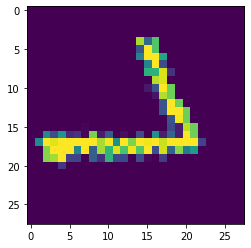

In [6]:
img, label = val_dataset[0]

plt.imshow(img[0])
print(label)

In [7]:
img.shape

(1, 28, 28)

#### 1.3.1. Constant Current Encoding

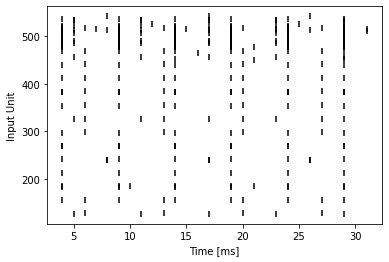

In [8]:
T = 32
cce = norse.torch.ConstantCurrentLIFEncoder(T)

cce_input = cce(torch.tensor(img[0]))
cce_spikes = cce_input.reshape(T, 28*28).to_sparse().coalesce()
t = cce_spikes.indices()[0]
n = cce_spikes.indices()[1]

plt.scatter(t, n, marker='|', color='black')
plt.xlabel('Time [ms]')
plt.ylabel('Input Unit')
plt.show()

In [9]:
def CCE(img):
    return cce(torch.tensor(img))

In [10]:
cce_input.shape

torch.Size([32, 28, 28])

In [11]:
for data in val_loader:
    img, lab = data
    print(CCE(img).shape)
    break

torch.Size([32, 256, 1, 28, 28])


/tmp/ipykernel_21359/2001216082.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return cce(torch.tensor(img))


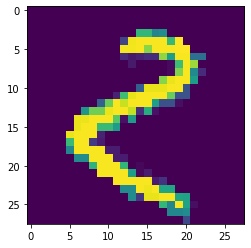

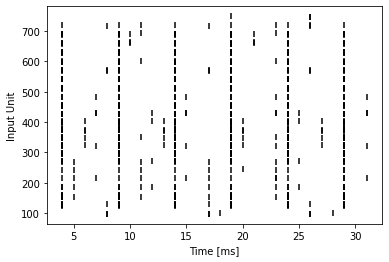

2


In [12]:
img, label = val_dataset[1]
plt.imshow(img[0])
plt.show()
spikes = CCE(img).reshape(-1, 28*28).to_sparse().coalesce()
t = spikes.indices()[0]
n = spikes.indices()[1]

plt.scatter(t, n, marker='|', color='black')
plt.xlabel('Time [ms]')
plt.ylabel('Input Unit')
plt.show()

print(label)

## 2. Learning

### 2.1. LIFRecurrentCell

In [13]:
from norse.torch import LIFParameters, LIFState
from norse.torch.module.lif import LIFCell, LIFRecurrentCell
from norse.torch import LICell, LIState
from typing import NamedTuple

In [14]:
class SNNState(NamedTuple):
    lif0 : LIFState
    readout : LIState


class SNN(torch.nn.Module):
    def __init__(self, input_features, hidden_features, output_features, record=False, dt=0.001):
        super(SNN, self).__init__()
        self.l1 = LIFRecurrentCell(
            input_features,
            hidden_features,
            p=LIFParameters(alpha=100, v_th=torch.tensor(2.)),
            dt=dt                     
        )
        self.input_features = input_features
        self.fc_out = torch.nn.Linear(hidden_features, output_features, bias=False)
        self.out = LICell(dt=dt)

        self.hidden_features = hidden_features
        self.output_features = output_features
        self.record = record
        
    def forward(self, x):
        seq_length, batch_size, _, _, _ = x.shape
        s1 = so = None
        voltages = []

        if self.record:
            self.recording = SNNState(
                LIFState(
                    z = torch.zeros(seq_length, batch_size, self.hidden_features),
                    v = torch.zeros(seq_length, batch_size, self.hidden_features),
                    i = torch.zeros(seq_length, batch_size, self.hidden_features)
                ),
                LIState(
                    v = torch.zeros(seq_length, batch_size, self.output_features),
                    i = torch.zeros(seq_length, batch_size, self.output_features)
                )
            )

        for ts in range(seq_length):
            z = x[ts, :, :, :].view(-1, self.input_features)
            z, s1 = self.l1(z, s1)
            z = self.fc_out(z)
            vo, so = self.out(z, so)
            if self.record:
                self.recording.lif0.z[ts,:] = s1.z
                self.recording.lif0.v[ts,:] = s1.v
                self.recording.lif0.i[ts,:] = s1.i
                self.recording.readout.v[ts,:] = so.v
                self.recording.readout.i[ts,:] = so.i
            voltages += [vo]

        return torch.stack(voltages)

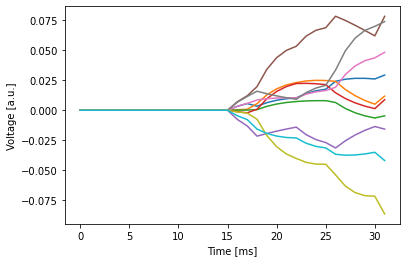

In [15]:
example_snn = SNN(28*28, 100, 10, record=True, dt=0.001)
img, label = val_dataset[1]
example_readout_voltages = example_snn(CCE(img).unsqueeze(1))
voltages = example_readout_voltages.reshape(-1, 10).detach().numpy()
plt.plot(voltages)
plt.ylabel('Voltage [a.u.]')
plt.xlabel('Time [ms]')
plt.show()

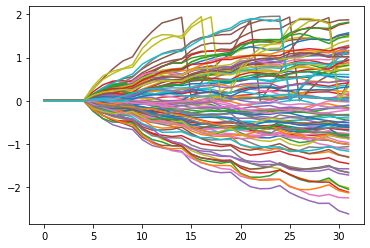

In [16]:
plt.plot(example_snn.recording.lif0.v.reshape(-1, 100).detach().numpy())
plt.show()

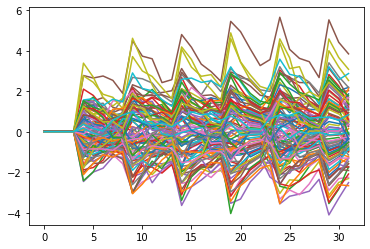

In [17]:
plt.plot(example_snn.recording.lif0.i.squeeze(1).detach().numpy())
plt.show()

### 2.2. Decoder

In [18]:
def decode(x):
    x, _ = torch.max(x, 0)
    log_p_y = torch.nn.functional.log_softmax(x, dim=1)
    return log_p_y

def decode_last(x):
    x = x[-1]
    log_p_y = torch.nn.functional.log_softmax(x, dim=1)
    return log_p_y

### 2.3. Define Main Network

In [19]:
class Model(torch.nn.Module):
    def __init__(self, encoder, snn, decoder):
        super(Model, self).__init__()
        self.encoder = encoder
        self.snn = snn
        self.decoder = decoder

    def forward(self, x):
        x = self.encoder(x)
        x = self.snn(x)
        log_p_y = self.decoder(x)
        return log_p_y

In [20]:
T = 32
LR = 0.002
INPUT_FEATURES = 28*28
HIDDEN_FEATURES = 100
OUTPUT_FEATURES = 10
DEVICE = 'cpu'
# if torch.cuda.is_available():
#     DEVICE = torch.device("cuda")
# else:
#     DEVICE = torch.device("cpu")

model = Model(
#     encoder=ConstantCurrentLIFEncoder(
#       seq_length=T,
#     ),
    encoder = CCE,
    snn=SNN(
      input_features=INPUT_FEATURES,
      hidden_features=HIDDEN_FEATURES,
      output_features=OUTPUT_FEATURES
    ),
    decoder=decode
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model

Model(
  (snn): SNN(
    (l1): LIFRecurrentCell(input_size=784, hidden_size=100, p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(2.), v_reset=tensor(0.), method='super', alpha=tensor(100)), autapses=False, dt=0.001)
    (fc_out): Linear(in_features=100, out_features=10, bias=False)
    (out): LICell(p=LIParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.)), dt=0.001)
  )
)

In [21]:
from tqdm.notebook import tqdm, trange

EPOCHS  = 10  # Increase this number for better performance 

def train(model, device, train_loader, optimizer, epoch, max_epochs):
    model.train()
    losses = []

    for (data, target) in tqdm(train_loader, leave=False):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.functional.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    mean_loss = np.mean(losses)
    return losses, mean_loss

In [22]:
def validate(model, device, val_loader, epoch):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += torch.nn.functional.nll_loss(
                output, target, reduction="sum"
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(val_loader.dataset)

    accuracy = 100.0 * correct / len(val_loader.dataset)

    return val_loss, accuracy

In [23]:
training_losses = []
mean_losses = []
val_losses = []
accuracies = []

torch.autograd.set_detect_anomaly(True)

for epoch in trange(EPOCHS):
    training_loss, mean_loss = train(model, DEVICE, train_loader, optimizer, epoch, max_epochs=EPOCHS)
    val_loss, accuracy = validate(model, DEVICE, val_loader, epoch)
    training_losses += training_loss
    mean_losses.append(mean_loss)
    val_losses.append(val_loss)
    accuracies.append(accuracy)
    print(f"val loss: {val_loss}, val acc: {accuracy}")

print(f"final accuracy: {accuracies[-1]}")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/235 [00:00<?, ?it/s]

/tmp/ipykernel_21359/2001216082.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return cce(torch.tensor(img))


val loss: 3.234153213119507, val acc: 28.7


  0%|          | 0/235 [00:00<?, ?it/s]

val loss: 3.4820961616516115, val acc: 30.34


  0%|          | 0/235 [00:00<?, ?it/s]

val loss: 3.634333610534668, val acc: 30.67


  0%|          | 0/235 [00:00<?, ?it/s]

val loss: 3.7707313262939453, val acc: 31.6


  0%|          | 0/235 [00:00<?, ?it/s]

val loss: 3.901355545043945, val acc: 31.53


  0%|          | 0/235 [00:00<?, ?it/s]

val loss: 3.9338489471435545, val acc: 31.78


  0%|          | 0/235 [00:00<?, ?it/s]

val loss: 4.016425409698487, val acc: 30.86


  0%|          | 0/235 [00:00<?, ?it/s]

val loss: 4.0959191963195805, val acc: 31.98


  0%|          | 0/235 [00:00<?, ?it/s]

val loss: 4.127184792327881, val acc: 31.52


  0%|          | 0/235 [00:00<?, ?it/s]

val loss: 4.263552071380615, val acc: 31.32
final accuracy: 31.32


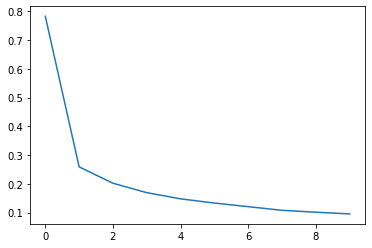

In [27]:
plt.plot(mean_losses)

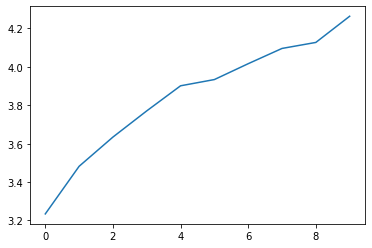

In [25]:
plt.plot(val_losses)

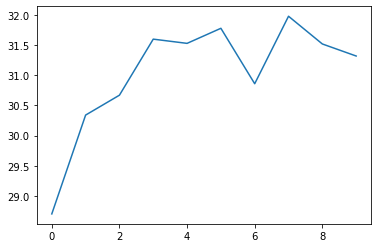

In [26]:
plt.plot(accuracies)